In [1]:
import numpy as np
import sinter
import matplotlib.pyplot as plt
import os

from qecdec import Sinter_BPDecoder, RotatedSurfaceCode

p = 0.005 # physical error rate
scaling_factor_list = np.arange(0, 1.0001, 0.05).tolist()

In [ ]:
def generate_sinter_tasks():
    for d in [5, 7, 9, 11]:
        code = RotatedSurfaceCode(d)
        circuit = code.make_circuit_memory_z_experiment(
            rounds=d,
            data_qubit_error_rate=p,
            meas_error_rate=p,
            keep_z_detectors_only=True,
        )
        for scaling_factor in scaling_factor_list:
            yield sinter.Task(
                circuit=circuit,
                decoder='bp(scaling_factor={})'.format(scaling_factor),
                json_metadata={
                    'p': p,
                    'd': d,
                    'scaling_factor': scaling_factor,
                },
            )

sinter_stats = sinter.collect(
    num_workers=os.cpu_count() - 1,
    max_shots=100_000,
    max_errors=100,
    tasks=generate_sinter_tasks(),
    custom_decoders={
        'bp(scaling_factor={})'.format(s): 
        Sinter_BPDecoder(max_iter=50, scaling_factor=s) 
        for s in scaling_factor_list
    },
    print_progress=True,
)

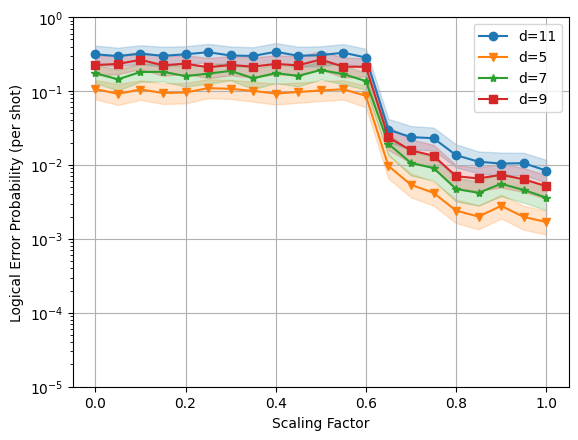

In [3]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=sinter_stats,
    group_func=lambda stat: f"d={stat.json_metadata['d']}",
    x_func=lambda stat: stat.json_metadata['scaling_factor'],
)
ax.semilogy()
ax.set_ylim(1e-5, 1)
ax.grid()
ax.set_ylabel('Logical Error Probability (per shot)')
ax.set_xlabel('Scaling Factor')
ax.legend()